In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# from microphone import record_audio # add if utilizing microphone and in Microphone directory
from IPython.display import Audio
from typing import Tuple
import librosa

from numba import njit
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure
from scipy.spatial.distance import cdist
from scipy.ndimage.morphology import iterate_structure

from typing import Tuple, Callable, List, Union

import uuid
import os
from pathlib import Path
from collections import Counter
import pickle

import wave, struct, librosa #important
from scipy.io import wavfile

from scipy import interpolate

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline

C:\Users\user\AppData\Local\Temp\ipykernel_11388\1179568901.py:10: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
C:\Users\user\AppData\Local\Temp\ipykernel_11388\1179568901.py:11: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure
C:\Users\user\AppData\Local\Temp\ipykernel_11388\1179568901.py:13: DeprecationWarning: Please use `iterate_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import iterate_structure


In [2]:
'''
DOESNT WORK WITH WAV FILES
def load_audio_file(file_path: str):
    """Loads a target audio file path.

    Parameters
    ----------
    file_path : str
        File path of song
        
    Returns
    -------
    recorded_audio: np.ndarray
        Audio samples
    """
    audio, samp_rate = librosa.load(file_path, sr=SAMPLING_RATE, mono=True)
    # audio = audio.astype(np.int16)     audio data converts to zeros
    return audio

def audio_file_to_array(file_path):
    """
    input: file path
    output: np array audio
    """
    with open(file_path,'rb') as audio_file:
        header = audio_file.read(44) # In WAV files, first 44 bytes are reserved for the header
        data_chunk_size = struct.unpack('<I', header[40:44])[0]
        audio_file.seek(44)
        data = audio_file.read(data_chunk_size)

        #Read the data from the file
        audio_file.seek(44)
        data = audio_file.read(data_chunk_size)

    # Converting the raw binary data to a list of integers : 
    print(data)
    data_array = np.frombuffer(data, dtype=np.int32)
    # Convert to float32
    data_array = data_array.astype(np.int16)

    return data_array #type int16

def convert_mic_frames_to_audio(frames: np.ndarray) -> np.ndarray:
    """Converts frames taken from microphone to 16-bit integers
    
    Parameters
    ----------
    frames : np.ndarray
        List of bytes recorded from a microphone
        
    Returns
    -------
    numpy.ndarray
        Bytes converted to 16-bit integers
    """
    return np.hstack([np.frombuffer(i, np.int16) for i in frames])
'''

def load_audio_file(filepath: str):
    
    samplerate, data = wavfile.read(filepath)
    '''
    NEW_SAMPLERATE = 44100
    old_samplerate, old_audio = wavfile.read(filepath)
    
    if old_samplerate != NEW_SAMPLERATE:
        duration = old_audio.shape[0] / old_samplerate
        time_old  = np.linspace(0, duration, old_audio.shape[0])
        time_new  = np.linspace(0, duration, int(old_audio.shape[0] * NEW_SAMPLERATE / old_samplerate))
        interpolator = interpolate.interp1d(time_old, old_audio.T)
        new_audio = interpolator(time_new).T
        wavfile.write(filepath, NEW_SAMPLERATE, np.round(new_audio).astype(old_audio.dtype))
        return wavfile.read(filepath)
    '''
    return samplerate, data

def dig_samp_to_spec_plot(sr,samples: np.ndarray):
    # data = np.hstack([np.frombuffer(i, np.int16) for i in frames])

    # using matplotlib's built-in spectrogram function
    fig, ax = plt.subplots()

    S, freqs, times, im = ax.specgram(
        samples,
        NFFT=4096,
        Fs=sr,
        window=mlab.window_hanning,
        noverlap=4096 // 2,
        mode='magnitude'
    )
    ax.set_ylim(0, 4000)
    ax.set_xlabel("time (sec)")
    ax.set_ylabel("frequency (Hz)")
    return fig, ax

def dig_samp_to_spec(sr, samples: np.ndarray):
    """Takes a 1-D sampled audio array and returns a 2-D spectrogram."""
    
    S, freqs, times = mlab.specgram(
    samples,
    NFFT=4096,
    Fs=sr,
    window=mlab.window_hanning,
    noverlap=int(4096 / 2),
    mode='magnitude'
    )

    return S

@njit
def _peaks(data_2d, rows, cols, amp_min):
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    rows : numpy.ndarray, shape-(N,)
        The 0-centered row indices of the local neighborhood mask
    
    cols : numpy.ndarray, shape-(N,)
        The 0-centered column indices of the local neighborhood mask
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location. 
    """
    peaks = []
    
    # iterate over the 2-D data in col-major order
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            continue

        for dr, dc in zip(rows, cols):
            if dr == 0 and dc == 0:
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                dr *= -1

            if not (0 <= c + dc < data_2d.shape[1]):
                dc *= -1

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                break
        else:
            peaks.append((r, c))
    return peaks

def local_peak_locations(data_2d, neighborhood, amp_min):
    """
    From 
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location.
    
    Notes
    -----
    The local peaks are returned in column-major order.
    """
    rows, cols = np.where(neighborhood)
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    rows -= neighborhood.shape[0] // 2
    cols -= neighborhood.shape[1] // 2
    
    return _peaks(data_2d, rows, cols, amp_min=amp_min)

### Turn peaks to fingerprints ###
def local_peaks_to_fingerprints(local_peaks: List[Tuple[int, int]], num_fanout: int):
    """Returns the fingerprint a set of peaks packaged as a tuple.

    Parameters
    ----------
    local_peaks : List[Tuple[int, int]]
        List of row, column (frequency, time) indexes of the peaks

    num_fanout : int
         Number of fanout points for each reference point

    Returns
    -------
    List[Tuple[int, int, int]]
        List of fingerprints"""
    
    result = [] #should be a list of lists

    if num_fanout <= len(local_peaks):
        for i in range(len(local_peaks) - num_fanout): # subtract because it had to be only peaks after, and dont want index out of bounds error
            i_fingerprints = []
            i_freq, i_time = local_peaks[i]
            for j in range(1, num_fanout+1):
                f_freq, f_time = local_peaks[i+j]
                i_fingerprints.append((i_freq, f_freq, f_time - i_time))
            
            result += i_fingerprints # contatenate lists
        
        return result # should be a 2d list, that can then be zipped w the peaks if we need to know which peak its associated with
    else:
        return "IndexError"

def local_peaks_to_fingerprints_with_absolute_times(local_peaks: List[Tuple[int, int]], num_fanout: int):
    """Returns the fingerprint and absolute time of the fingerprint of a set of peaks.

    Parameters
    ----------
    local_peaks : List[Tuple[int, int]]
        List of row, column (frequency, time) indexes of the peaks

    num_fanout : int
         Number of fanout points for each reference point

    Returns
    -------
    List[Tuple[int, int, int]] contained the reference point frequency, 
    fanout term frequency, and change in time interval, and List[int] of the abs_times of fingerprints."""

    fingerprints = []
    abs_times = []
    
    if num_fanout <= len(local_peaks):
        for i in range(len(local_peaks) - num_fanout): # subtract because it had to be only peaks after, and dont want index out of bounds error
            i_freq, i_time = local_peaks[i]
            for j in range(1, num_fanout+1):
                f_freq, f_time = local_peaks[i+j]
                fingerprints.append((i_freq, f_freq, f_time - i_time))
                abs_times.append(i_time)
            
        
        return fingerprints, abs_times
    else:
        return "IndexError"

def file_path_to_fingerprints(file_path, amplitude_percentile: float=0.75, fanout_number: int=15):
    """Take the music file path of a song and returns it's fingerprints.

    Parameters
    ----------
    file_path : Union[str, Path]
        File path for music file

    amplitude_percentile : float, optional
         A demical < 1.0 for which all amplitudes less than the {percentile}
         percentile of amplitudes will be disregarded

    fanout_number: int, optional
        Number of fanouts for each reference point/peak in the spectrogram

    Returns
    -------
    List[Tuple[int, int, int]] contained the reference point frequency, 
    fanout term frequency, and change in time interval"""

    sr, samples = load_audio_file(file_path)

    S = dig_samp_to_spec(sr,samples)

    neighborhood = iterate_structure(generate_binary_structure(2, 1), 20)

    peak_locations = local_peak_locations(S, neighborhood, amp_min=find_cutoff_amp(S, amplitude_percentile)) #

    fingerprints = local_peaks_to_fingerprints(peak_locations, fanout_number)
   
    return fingerprints

def recorded_audio_to_fingerprints(recorded_audio):
    sr,samples = load_audio_file(file_path)

    S = dig_samp_to_spec(sr,samples)

    neighborhood = iterate_structure(generate_binary_structure(2, 1), 20)

    peak_locations = local_peak_locations(S, neighborhood, amp_min=find_cutoff_amp(S, amplitude_percentile)) #

    fingerprints = local_peaks_to_fingerprints(peak_locations, fanout_number)
   
    return fingerprints
    
'''
def amplitude_plot(file_name):
    """
    input: file path
    output: amplitude to time plot
    """
    data, sr = librosa.load(file_name, sr = 44100)
    plt.subplot(1,1,1)
    librosa.display.waveshow(data,sr=sr, x_axis = 'time')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude Waveform")
    plt.show()
'''

def process_all_songs(directory_path: str, num_fanout: int = 15) -> np.ndarray: # directory_path="/data"
    db = []
    
    for filename in os.listdir(directory_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory_path, filename)

            sr,audio = load_audio_file(file_path)
            S = dig_samp_to_spec(sr,audio)

            # Define neighborhood structure for peak detection
            neighborhood = generate_binary_structure(2, 1)
            neighborhood = iterate_structure(neighborhood, 20)

            # Detect peaks
            amp_min = find_cutoff_amp(S, 0.77)
            peaks = local_peak_locations(S, neighborhood, amp_min)

            # Generate fingerprints
            fingerprints = local_peaks_to_fingerprints(peaks, num_fanout)
            
            db.append([fingerprints])
    
    return np.array(db, dtype=object)

def find_cutoff_amp(S: np.ndarray, percentile: float):
    """Returns the log_amplitude of a target spectrogram that will be the cutoff for background noise
       in real world samples. Calculated using decimal part percentile.

    Parameters
    ----------
    S : numpy.ndarray
        The target spectrogram

    percentile : float
         A demical < 1.0 for which the cutoff is greater than or equal to the {percentile}
         percentile of log_amplitudes

    Returns
    -------
    Cutoff amplitude"""

    S = S.ravel()  # ravel flattens 2D spectrogram into a 1D array
    ind = round(len(S) * percentile)  # find the index associated with the percentile amplitude
    cutoff_amplitude = np.partition(S, ind)[ind]  # find the actual percentile amplitude
    
    return cutoff_amplitude

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time (sec)', ylabel='frequency (Hz)'>)

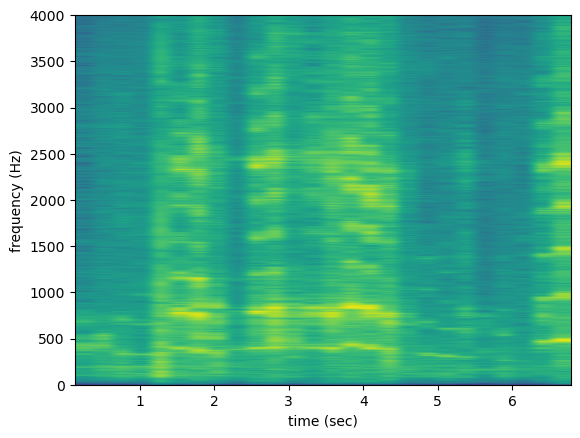

In [11]:
import random
filepath = str("data/crying/"+random.choice(os.listdir("data/crying/")))
sr,test = load_audio_file(filepath)
dig_samp_to_spec_plot(sr,test)

In [16]:
file_path_to_fingerprints(filepath)

[(55, 101, 0),
 (55, 129, 0),
 (55, 399, 1),
 (55, 590, 2),
 (55, 789, 2),
 (55, 960, 2),
 (55, 203, 5),
 (55, 1215, 5),
 (55, 1418, 5),
 (55, 622, 6),
 (55, 1247, 6),
 (55, 1455, 6),
 (55, 1488, 6),
 (55, 1700, 6),
 (55, 1875, 6),
 (101, 129, 0),
 (101, 399, 1),
 (101, 590, 2),
 (101, 789, 2),
 (101, 960, 2),
 (101, 203, 5),
 (101, 1215, 5),
 (101, 1418, 5),
 (101, 622, 6),
 (101, 1247, 6),
 (101, 1455, 6),
 (101, 1488, 6),
 (101, 1700, 6),
 (101, 1875, 6),
 (101, 1915, 6),
 (129, 399, 1),
 (129, 590, 2),
 (129, 789, 2),
 (129, 960, 2),
 (129, 203, 5),
 (129, 1215, 5),
 (129, 1418, 5),
 (129, 622, 6),
 (129, 1247, 6),
 (129, 1455, 6),
 (129, 1488, 6),
 (129, 1700, 6),
 (129, 1875, 6),
 (129, 1915, 6),
 (129, 1947, 6),
 (399, 590, 1),
 (399, 789, 1),
 (399, 960, 1),
 (399, 203, 4),
 (399, 1215, 4),
 (399, 1418, 4),
 (399, 622, 5),
 (399, 1247, 5),
 (399, 1455, 5),
 (399, 1488, 5),
 (399, 1700, 5),
 (399, 1875, 5),
 (399, 1915, 5),
 (399, 1947, 5),
 (399, 680, 9),
 (590, 789, 0),
 (590,

In [ ]:
process_all_songs("data/other/")

In [ ]:
all_fingerprints

In [ ]:
def cutoff_similarity(): #recorded_audio = convert_mic_frames_to_audio
    # find smallest value of cos_sim across all fingerprints
    # help lol
    diffs = []
    for fp in all_fingerprints:
        diffs += [cos_sim(fp, fp2) for fp2 in all_fingerprints]
    return min(diffs)

In [ ]:
def compare(recorded_audio):
    sim = cos_sim(record_audio, 